<a href="https://colab.research.google.com/github/ClaudiaAnton/CVDL/blob/main/food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d kmader/food41

100% 5.28G/5.30G [00:40<00:00, 187MB/s]
100% 5.30G/5.30G [00:41<00:00, 139MB/s]


In [ ]:
!unzip /content/food41.zip

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape
from keras import Input, Model

In [ ]:
image_dir = Path('/content/images')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for label in images['Label'].unique():
    subset = images[images['Label'] == label]
    sample = subset.sample(100, random_state=1)
    category_samples.append(sample)

image_df = pd.concat(category_samples, axis=0)
image_df = image_df.sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
print(image_df)

                                          Filepath             Label
0              /content/images/risotto/2637062.jpg           risotto
1            /content/images/apple_pie/3004621.jpg         apple_pie
2               /content/images/sashimi/208014.jpg           sashimi
3               /content/images/ravioli/340945.jpg           ravioli
4              /content/images/waffles/1726447.jpg           waffles
...                                            ...               ...
10095         /content/images/ice_cream/627510.jpg         ice_cream
10096    /content/images/chicken_wings/2651737.jpg     chicken_wings
10097  /content/images/chocolate_mousse/149779.jpg  chocolate_mousse
10098      /content/images/french_toast/177481.jpg      french_toast
10099         /content/images/pork_chop/527832.jpg         pork_chop

[10100 rows x 2 columns]


In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    rotation_range=10,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   zoom_range=0.2,
                   channel_shift_range=10,
                   shear_range=0.05,
                   horizontal_flip=True,
                  validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                  rotation_range=10,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   zoom_range=0.2,
                   channel_shift_range=10,
                   shear_range=0.05,
                   horizontal_flip=True)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


In [ ]:
pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(244, 244, 3),pooling='avg')
pretrained_model.trainable = False

In [ ]:
from keras import metrics
def top_5_accuracy(y_true, y_pred):
  return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top_5_accuracy])
checkpointer = ModelCheckpoint(filepath='resnet50.hdf5', verbose=1, save_best_only=True)

In [ ]:

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    verbose=1,
    callbacks=[checkpointer],
)

Epoch 1/10
177/177 [==============================] - ETA: 0s - loss: 4.0451 - accuracy: 0.1123 - top_5_accuracy: 0.2748
Epoch 1: val_loss improved from inf to 3.38359, saving model to resnet50.hdf5
177/177 [==============================] - 693s 4s/step - loss: 4.0451 - accuracy: 0.1123 - top_5_accuracy: 0.2748 - val_loss: 3.3836 - val_accuracy: 0.1874 - val_top_5_accuracy: 0.4463
Epoch 2/10
177/177 [==============================] - ETA: 0s - loss: 2.8954 - accuracy: 0.2905 - top_5_accuracy: 0.5792
Epoch 2: val_loss improved from 3.38359 to 2.94735, saving model to resnet50.hdf5
177/177 [==============================] - 680s 4s/step - loss: 2.8954 - accuracy: 0.2905 - top_5_accuracy: 0.5792 - val_loss: 2.9474 - val_accuracy: 0.2631 - val_top_5_accuracy: 0.5700
Epoch 3/10
177/177 [==============================] - ETA: 0s - loss: 2.4224 - accuracy: 0.3784 - top_5_accuracy: 0.6812
Epoch 3: val_loss improved from 2.94735 to 2.79651, saving model to resnet50.hdf5
177/177 [==============

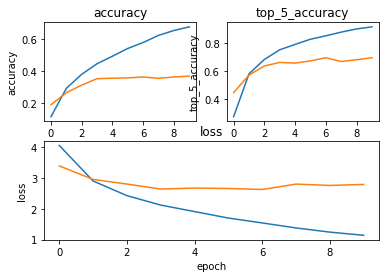

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)

# accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

plt.subplot(222)
plt.plot(history.history['top_5_accuracy'])
plt.plot(history.history['val_top_5_accuracy'])
plt.title('top_5_accuracy')
plt.ylabel('top_5_accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')

# loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='bott left')
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=1)

95/95 [==============================] - 302s 3s/step - loss: 2.8342 - accuracy: 0.3574 - top_5_accuracy: 0.6614


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

95/95 [==============================] - 293s 3s/step


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_images.labels, predictions)

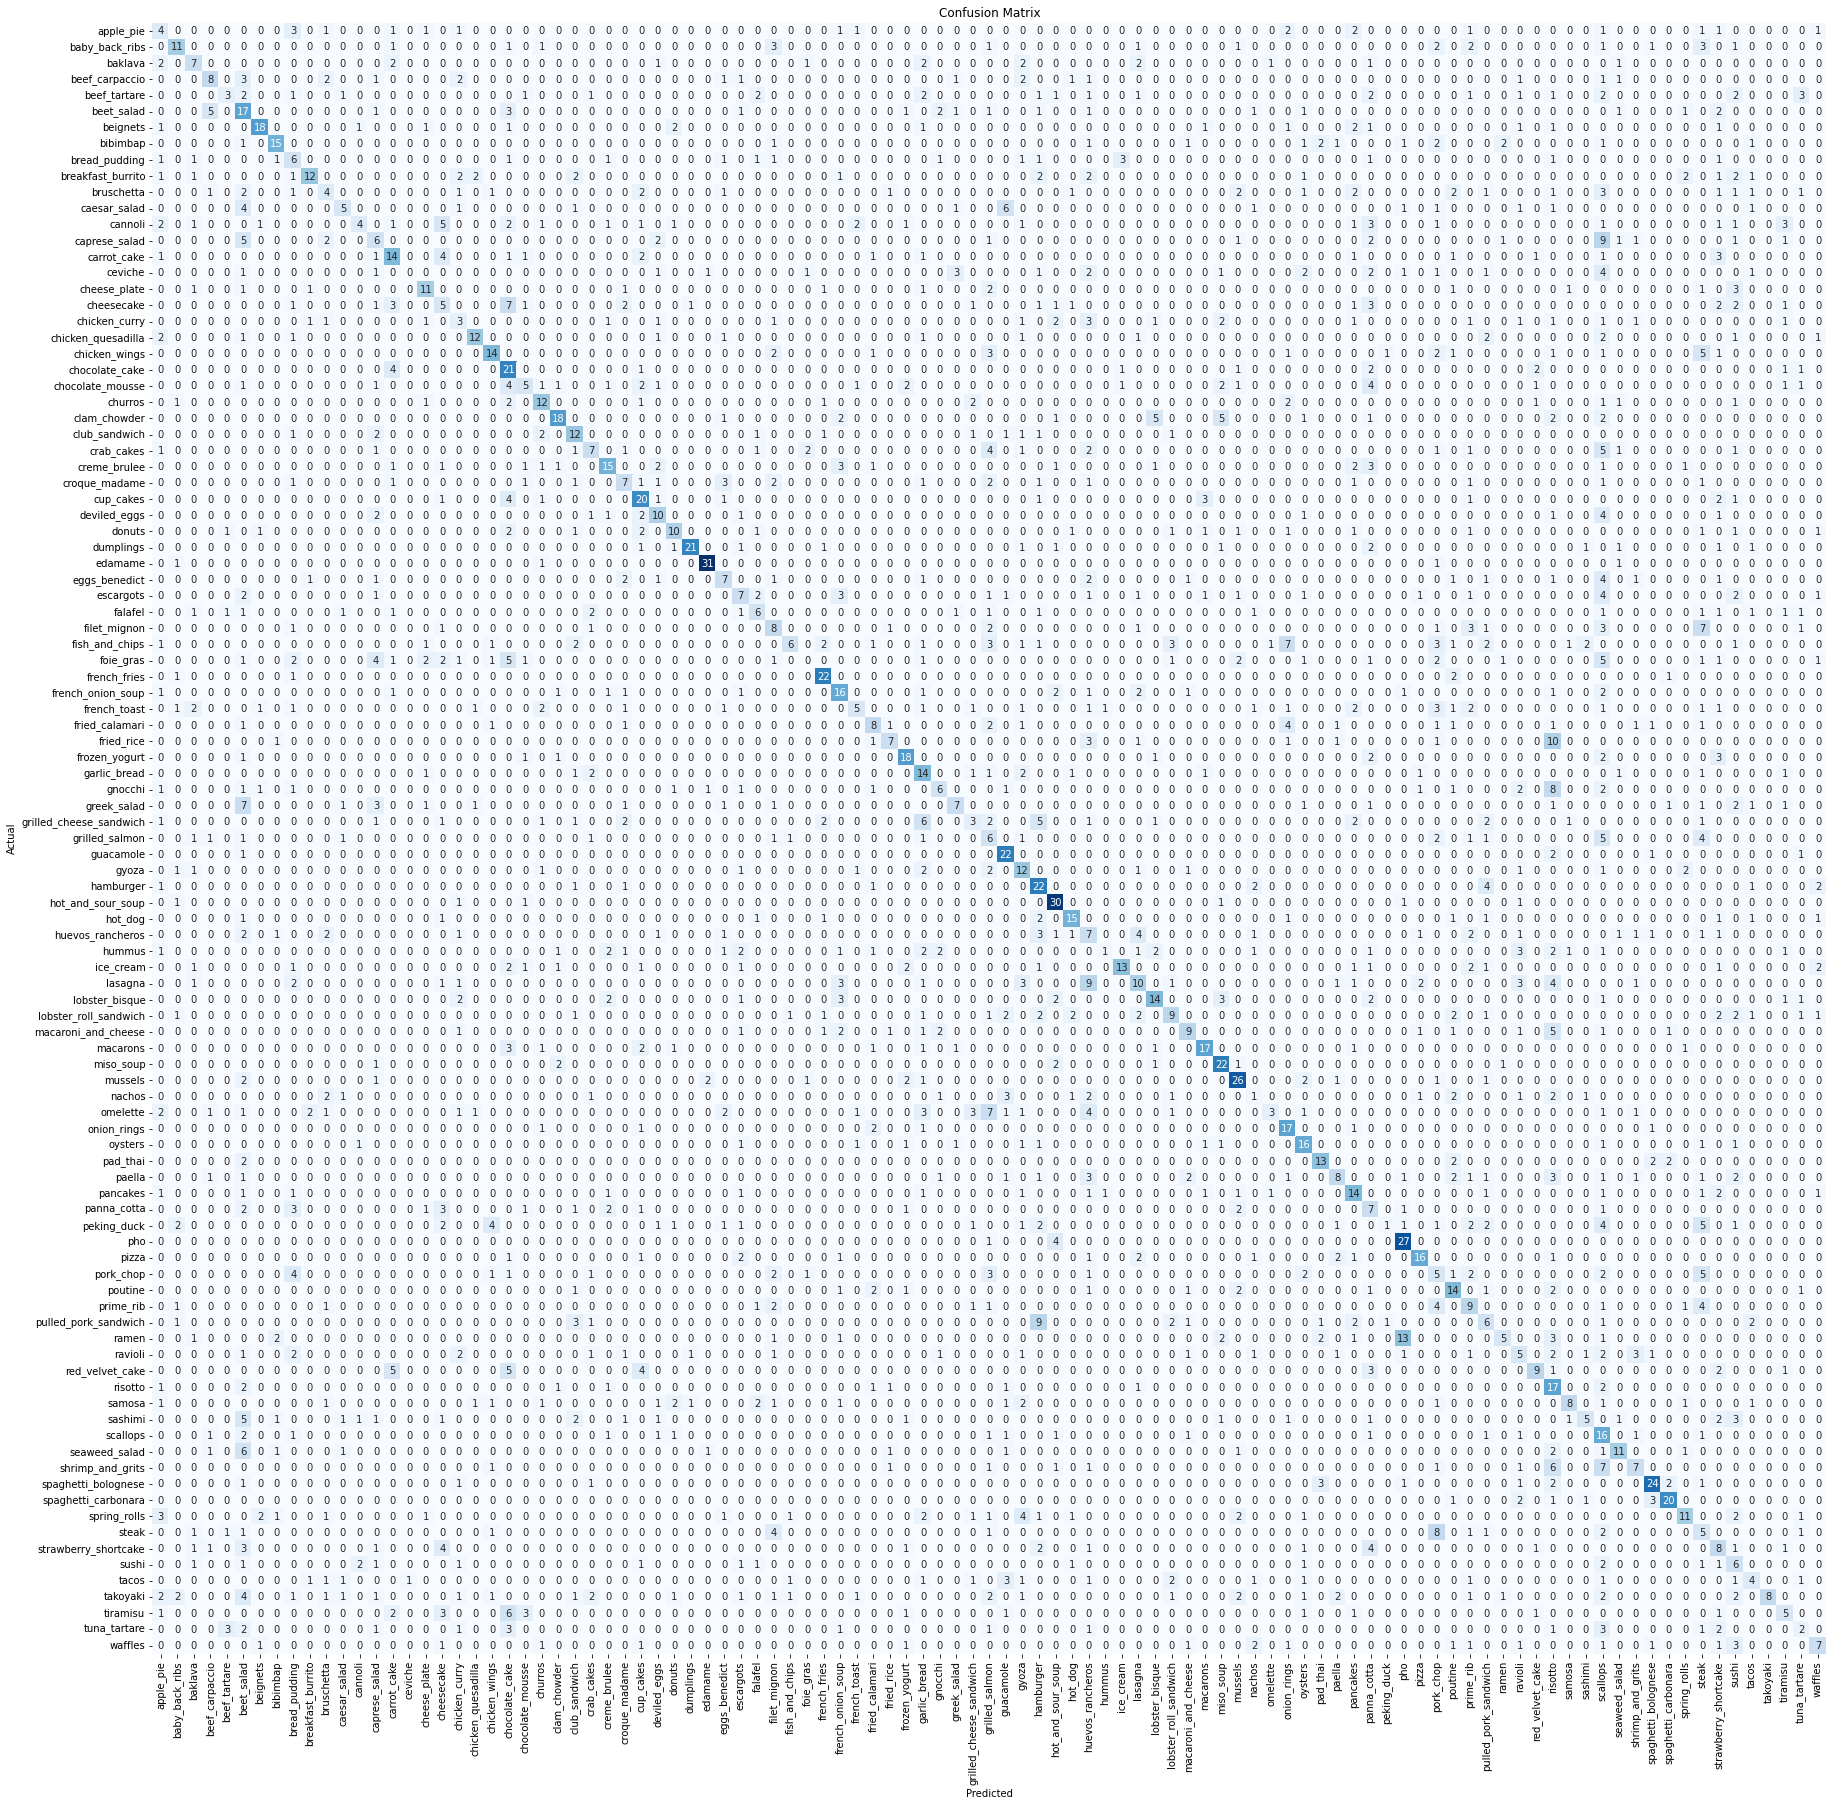

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()